In [3]:
from typing import List

import numpy as np
import torch as t
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

In [39]:
from matplotlib import animation, cm
from matplotlib import cbook


def U(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return c * min((x[0]-a)**2, (x[1]-b)**2)


def grad_U(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return np.array([
        2 * c * max((x[0] - a), 0.),
        2 * c * max((x[1] - b), 0.),
    ])

def K(v: np.ndarray):
    return - 1/2 * np.dot(v, v)

def accel(x: np.ndarray, v: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return -grad_U(x, a=a, b=b, c=c) 

def H(x: np.ndarray, v: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return U(x, a=a, b=b, c=c) + K(v)

# Plot the hamiltonian

def get_U_contour(a=0., b=0., c: float = 1, zlim=1., x_lim=(-1, 1), y_lim=(-1, 1)):
    x = np.linspace(x_lim[0], x_lim[1], 100)
    y = np.linspace(y_lim[0], y_lim[1], 100)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = U(np.array([X[i, j], Y[i, j]]), a=a, b=b, c=c)

            if Z[i, j] > zlim:
                Z[i, j] = zlim

    return X, Y, Z


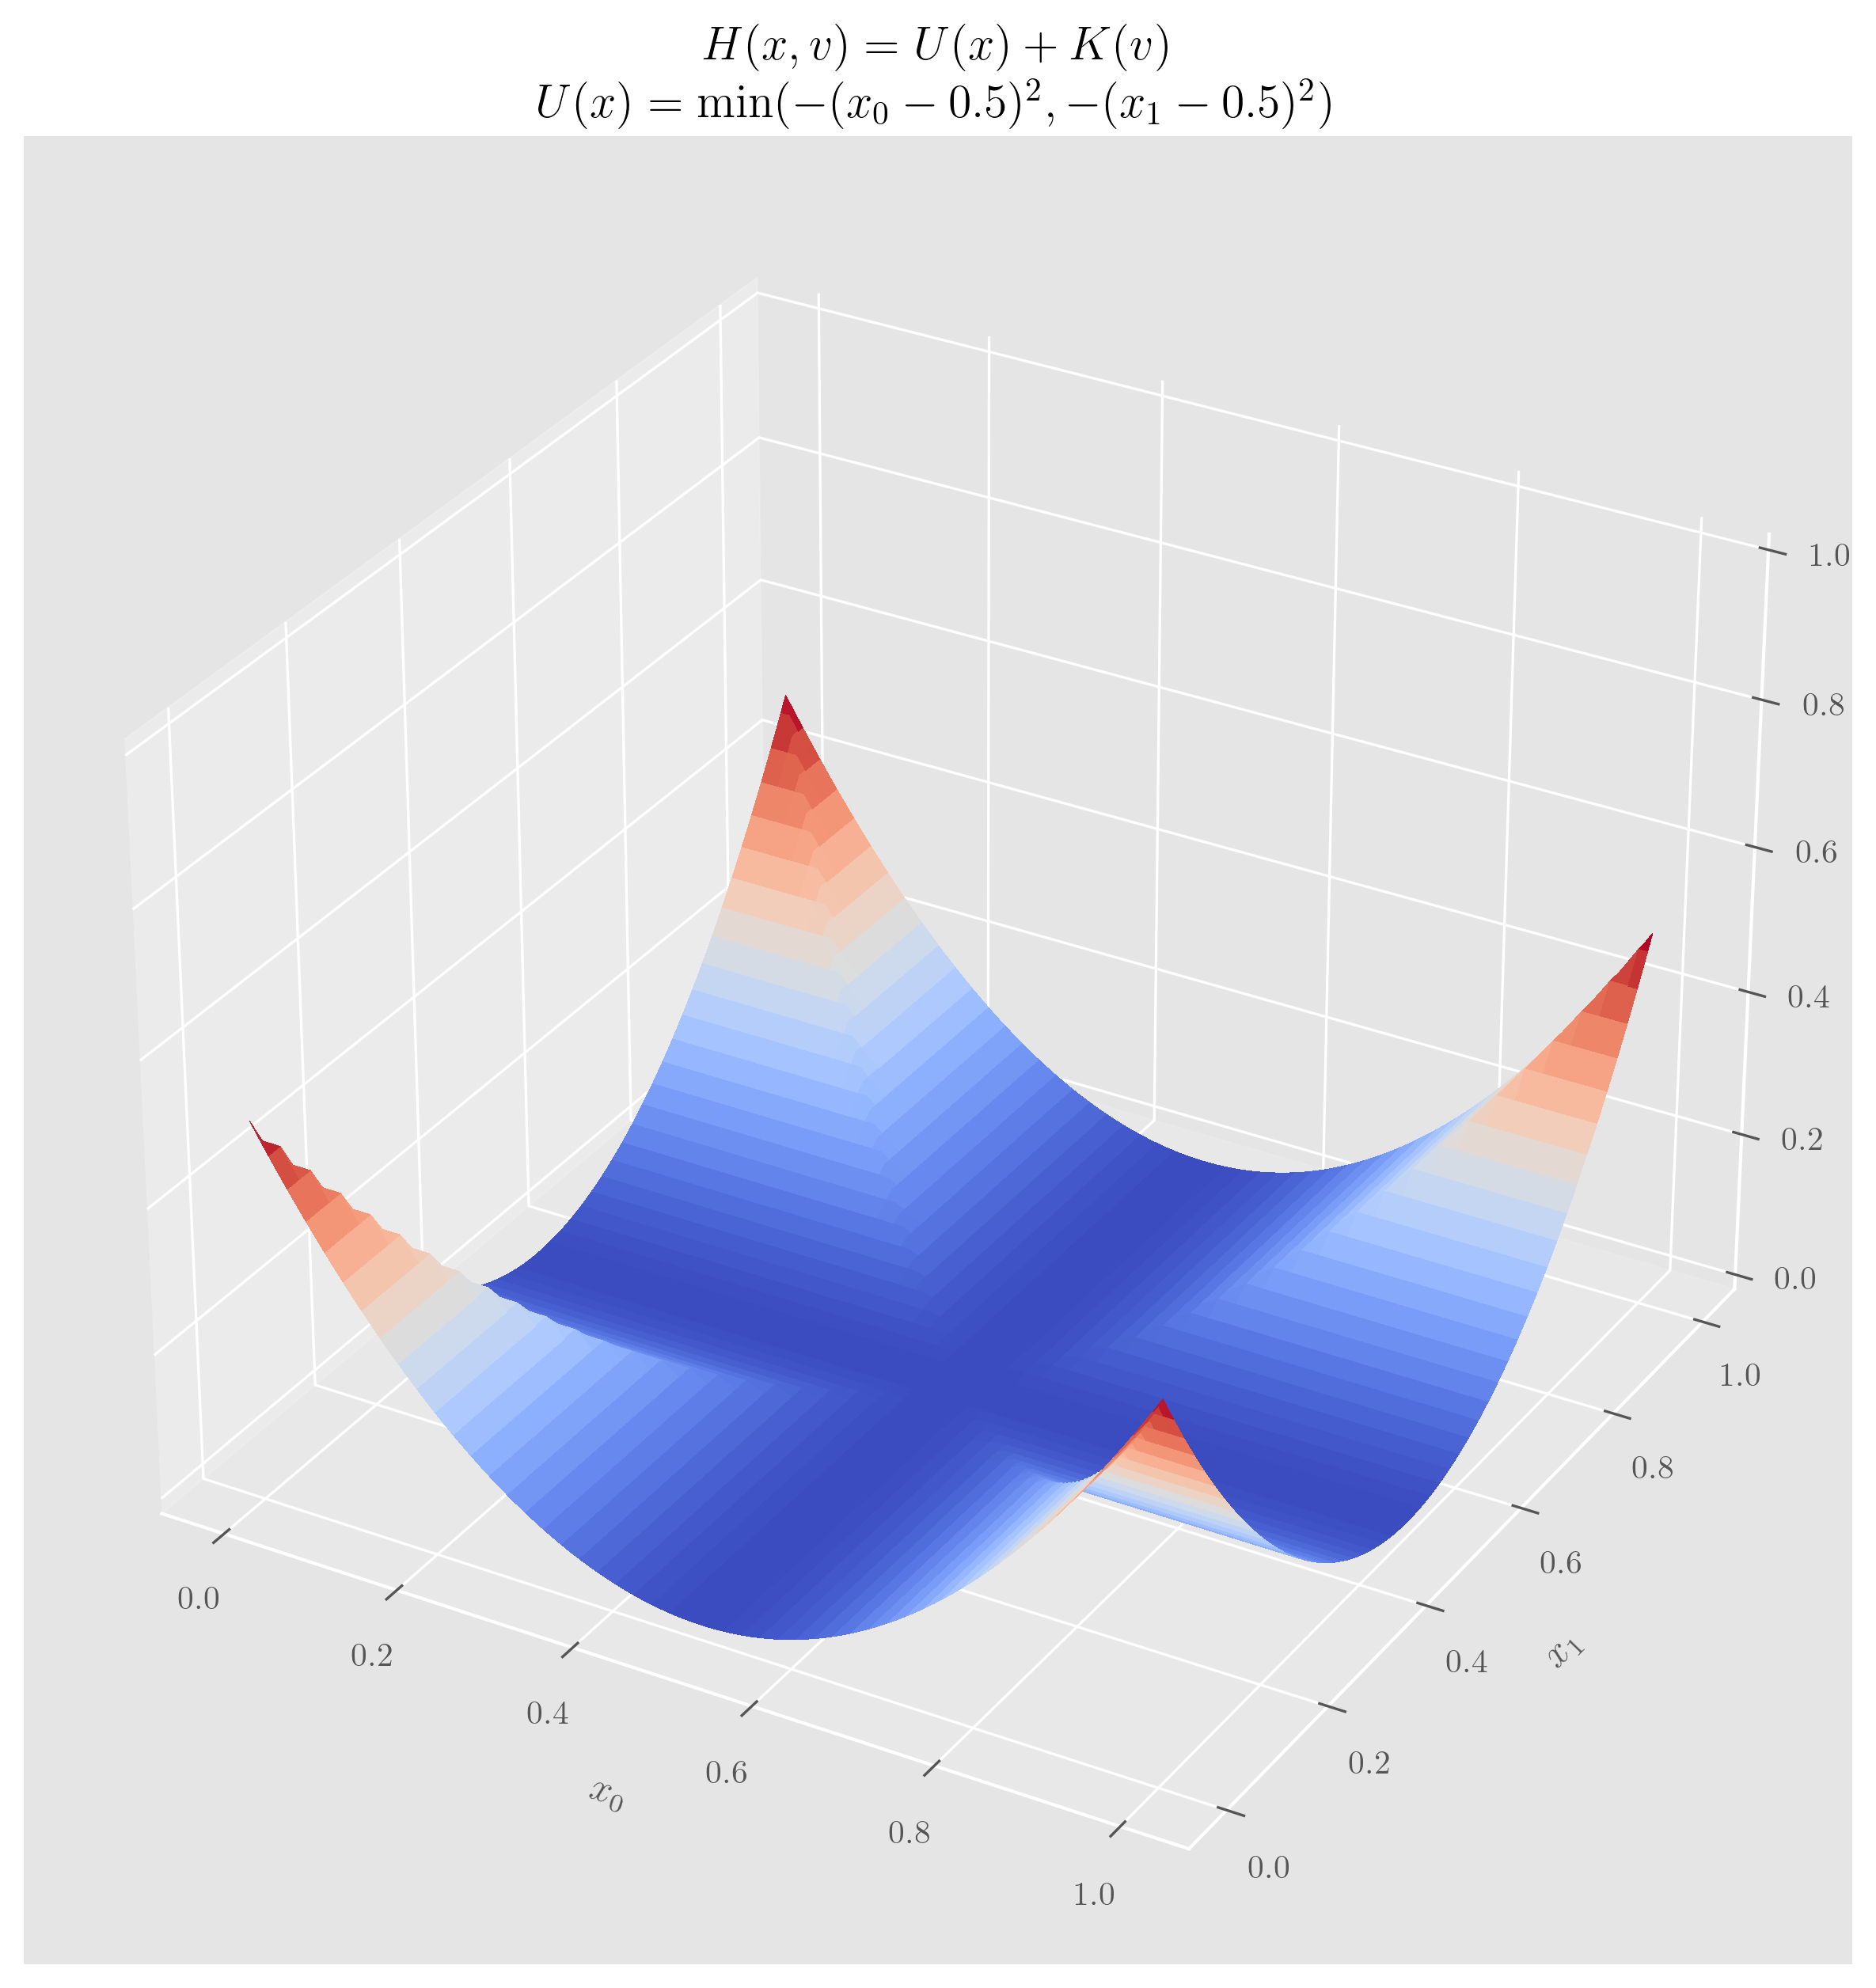

In [40]:

def plot_U_3D(a=0., b=0., c: float = 1, zlim=1., x_lim=(-1, 1), y_lim=(-1, 1)):
    X, Y, Z = get_U_contour(a=a, b=b, c=c, zlim=zlim, x_lim=x_lim, y_lim=y_lim)

    # In 3D
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Max height = 1
    ax.set_zlim(0, zlim)

    ax.set_title(f"$H(x, v) = U(x) + K(v)$\n$U(x) = \min(-(x_0-{a})^2, -(x_1-{b})^2)$")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return fig, ax

plot_U_3D(a=0.5, b=0.5, c=2, x_lim=(0, 1), y_lim=(0, 1))
plt.show()

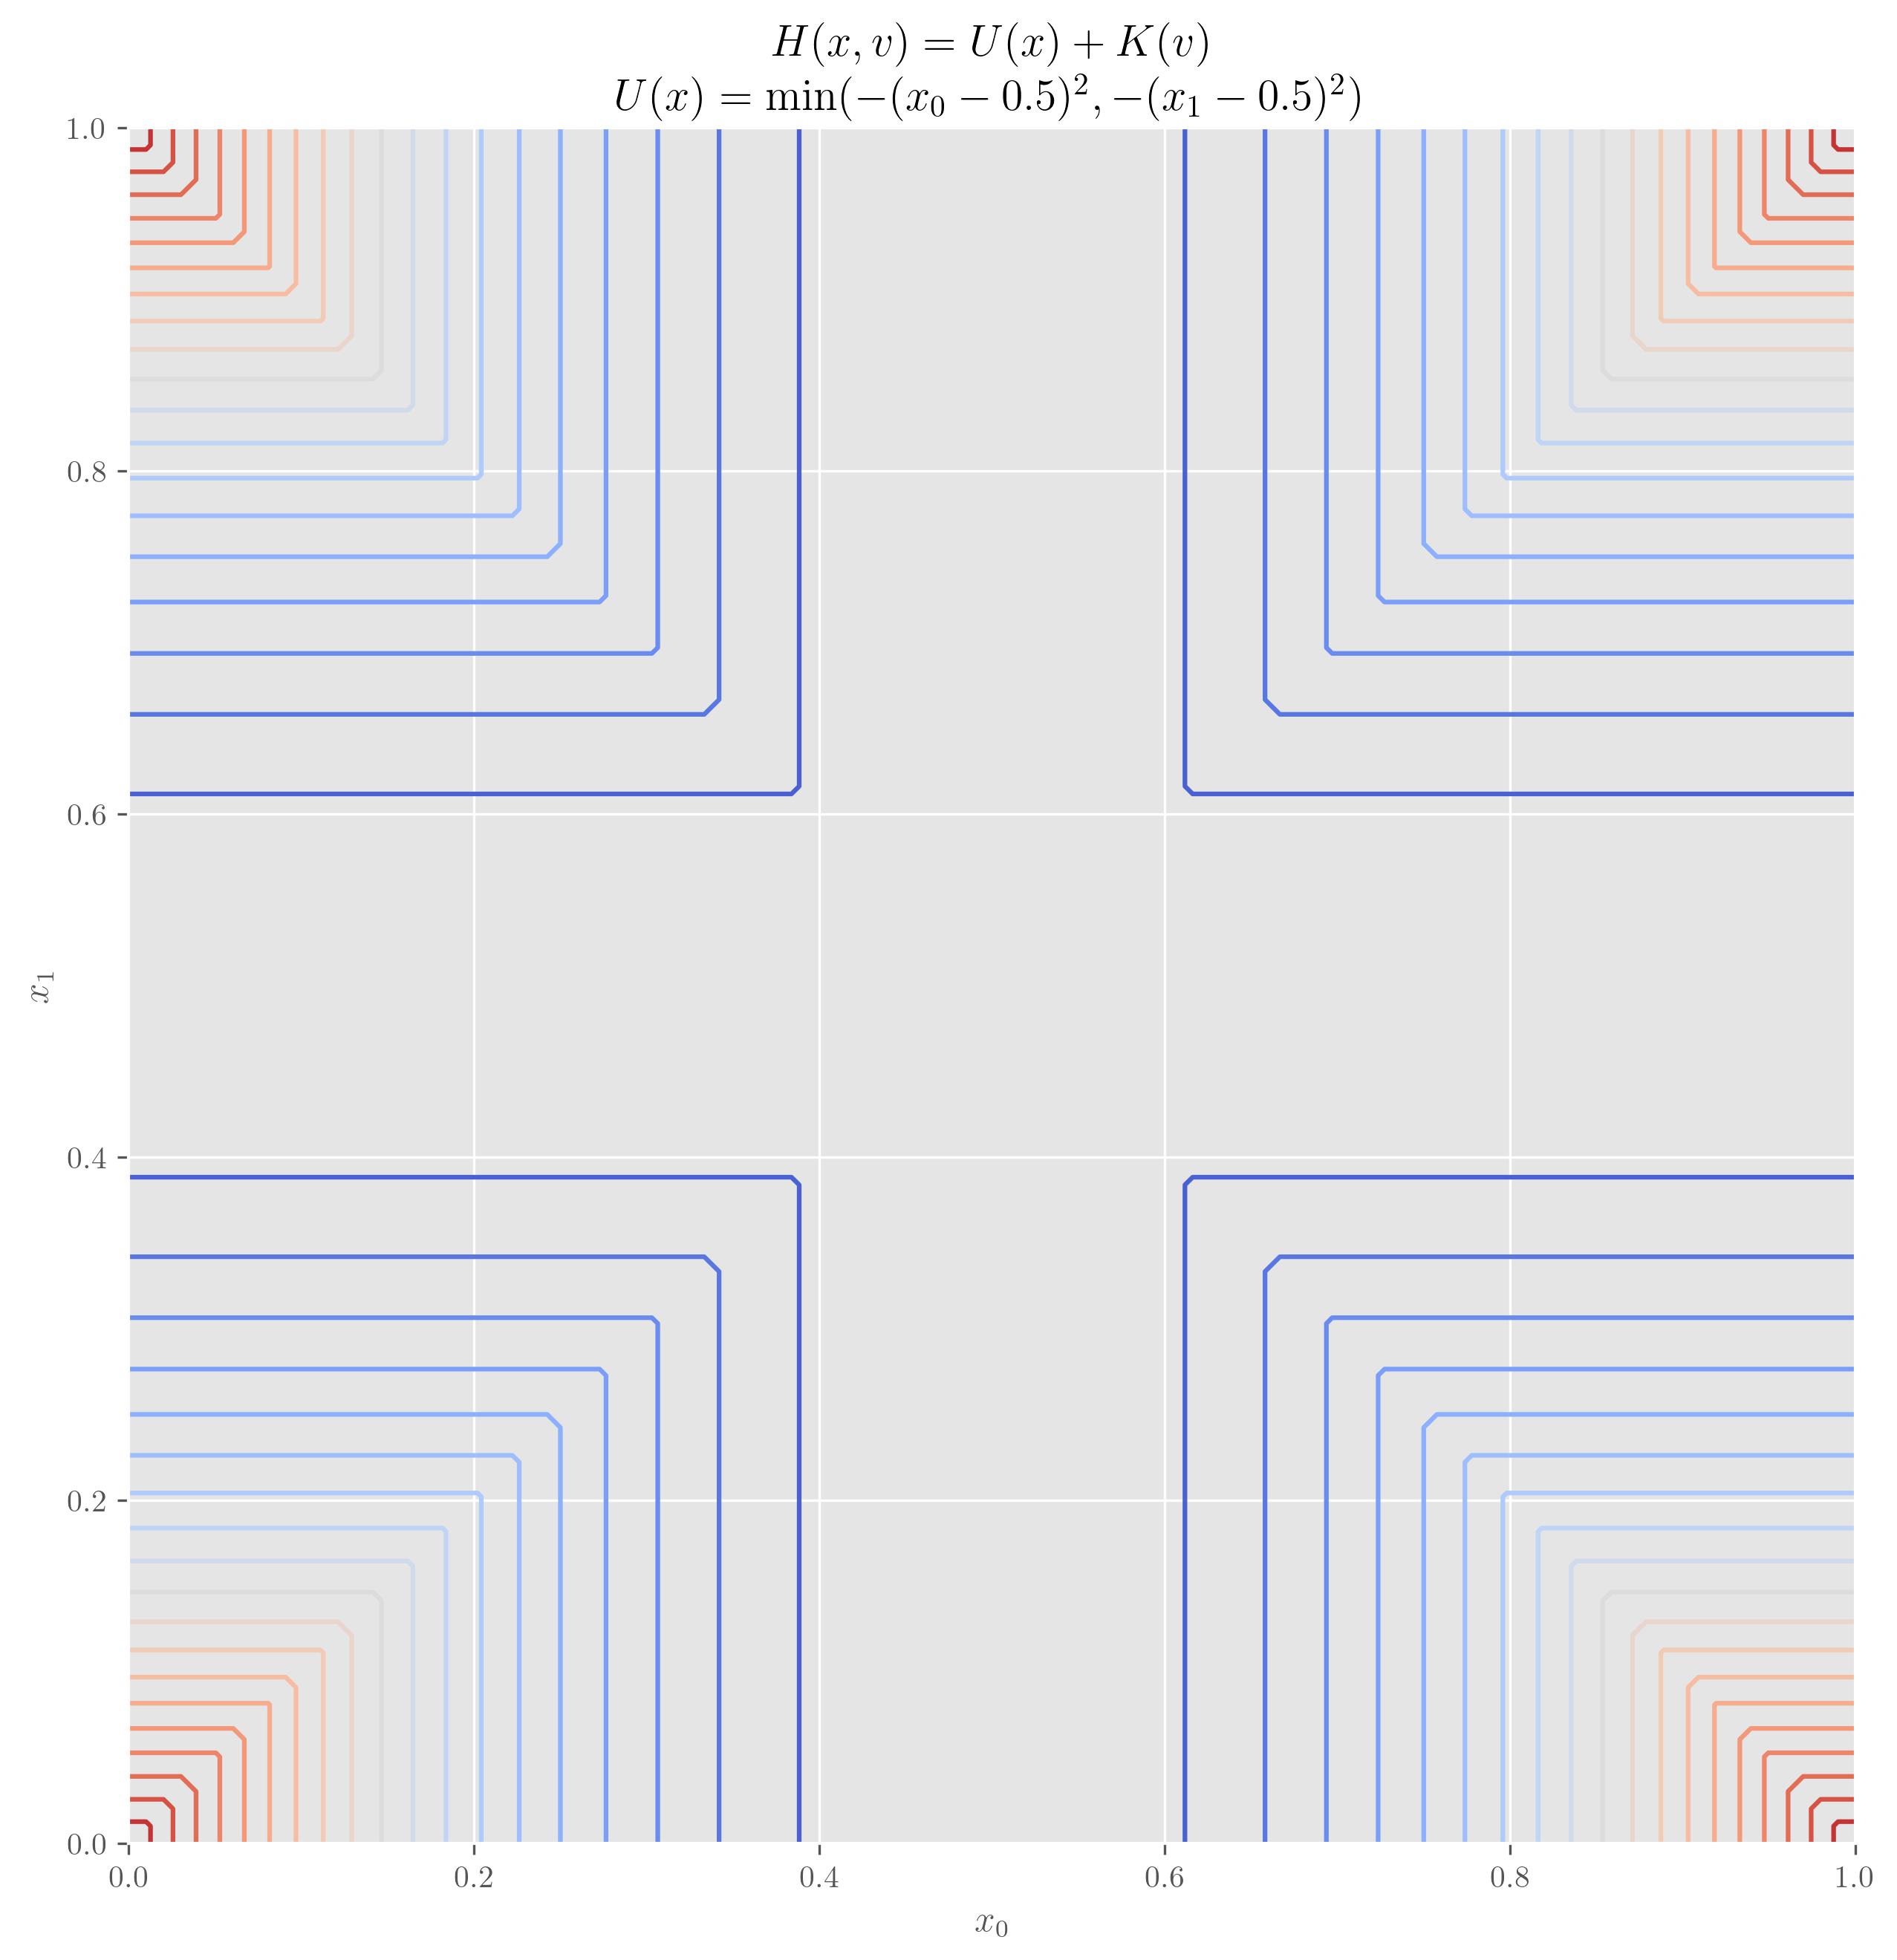

In [46]:

def plot_U_2D(a=0., b=0., c: float = 1, zlim=1., x_lim=(-1, 1), y_lim=(-1, 1)):
    X, Y, Z = get_U_contour(a=a, b=b, c=c, zlim=zlim, x_lim=x_lim, y_lim=y_lim)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.contour(X, Y, Z, levels=20, cmap=cm.coolwarm)
    ax.set_title(f"$H(x, v) = U(x) + K(v)$\n$U(x) = \min(-(x_0-{a})^2, -(x_1-{b})^2)$")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return fig, ax

plot_U_2D(a=0.5, b=0.5, c=2, zlim=1., x_lim=(0, 1), y_lim=(0, 1))
plt.show()

In [47]:
def simulate_particle(a = 0.5, b = 0.5, c: float = 1., x0: np.ndarray = np.array([0., 0.]), v0: np.ndarray = np.array([0., 0.]), dt: float = 0.01, n_steps: int = 1000, noise: float = 0., xlim=(0., 1.), ylim=(0., 1.)):
    x = x0
    v = v0

    xs = [x]
    vs = [v]

    for i in tqdm(range(n_steps), desc="Simulating particle..."):
        acc = accel(x, v, a=a, b=b, c=c) + np.random.normal(0, noise, size=2)
        x = x + dt * v
        v = v + dt * acc

        # Toroidal boundary conditions
        x[0] = (x[0] - xlim[0]) % (xlim[1] - xlim[0]) + xlim[0]
        x[1] = (x[1] - ylim[0]) % (ylim[1] - ylim[0]) + ylim[0]

        xs.append(x)
        vs.append(v)

    return np.array(xs), np.array(vs)

xs, ys = simulate_particle(a=0.5, b=0.5, c=2, x0=np.array([0.5, 0.5]), v0=np.array([0.5, 0.5]), dt=0.01, n_steps=1000, noise=0.1)

Simulating particle...:   0%|          | 0/1000 [00:00<?, ?it/s]

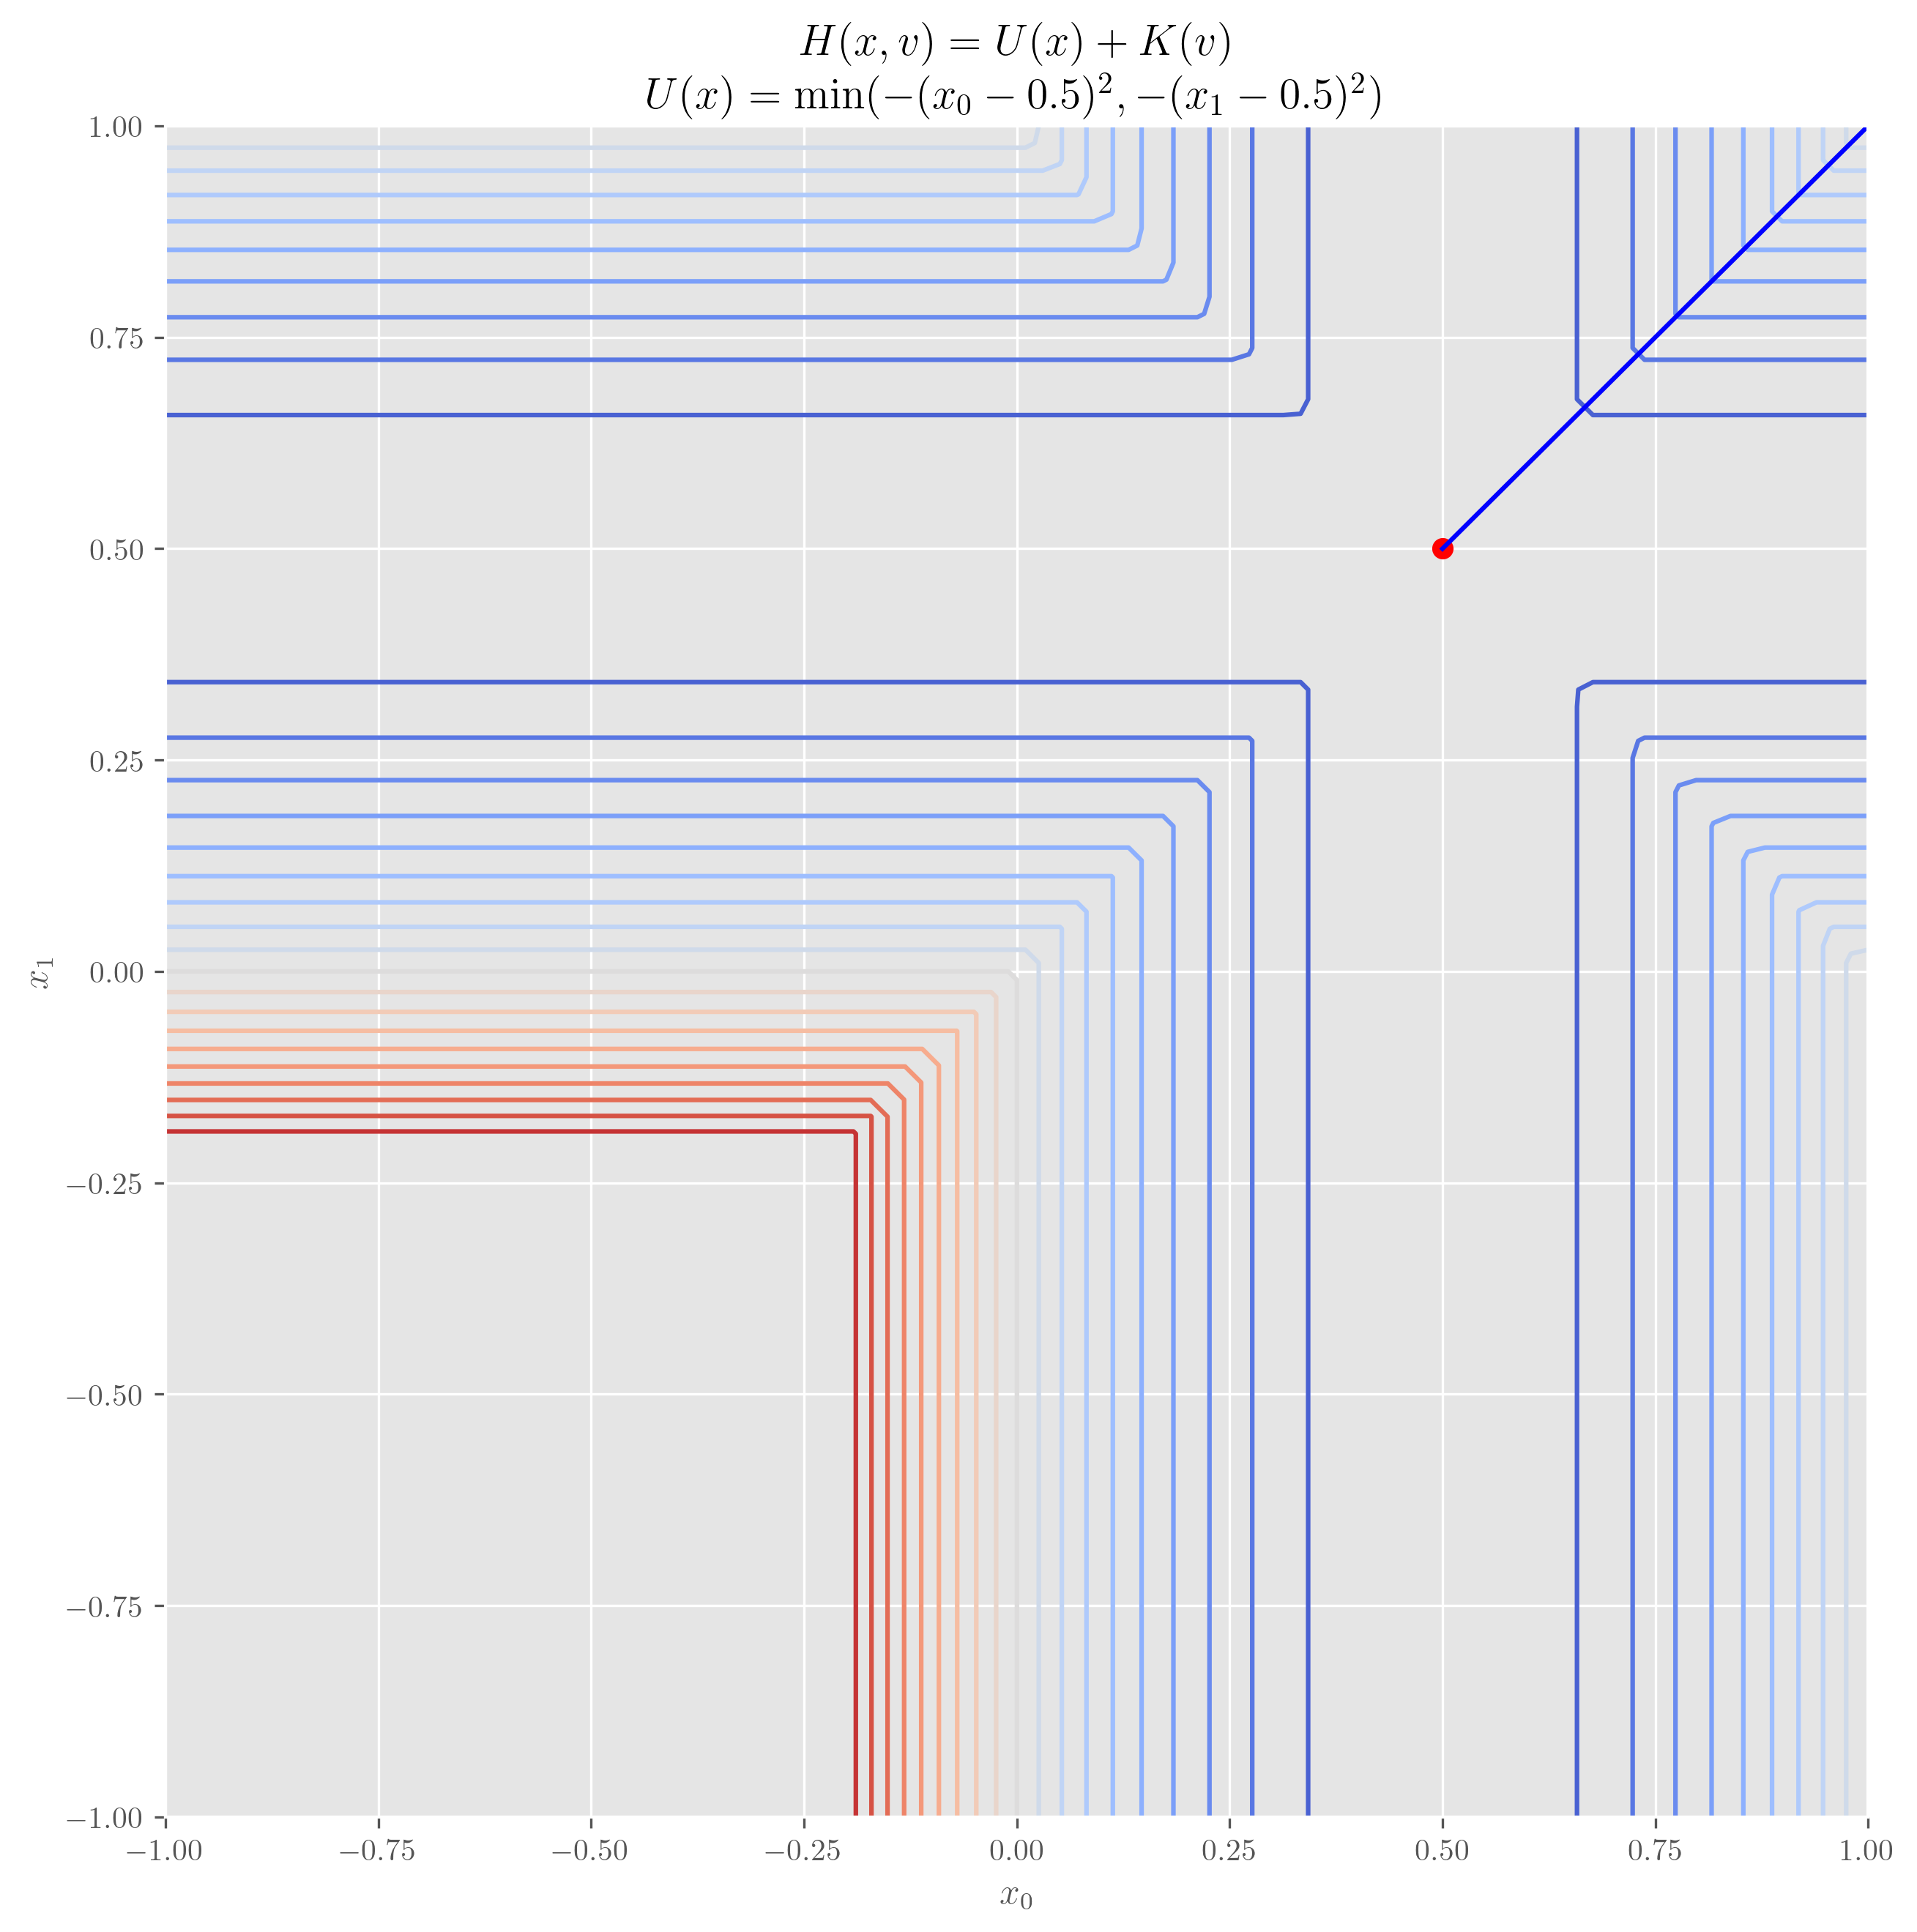

In [49]:
def animate_particle(xs: np.ndarray, vs: np.ndarray, a=0., b=0., c: float = 1., zlim=1., x_lim=(-1, 1), y_lim=(-1,1), fps: int = 30, save: bool = False, filename: str = "particle.mp4"):
    # Draw the point
    X, Y, Z = get_U_contour(a=a, b=b, c=c, zlim=zlim, x_lim=x_lim, y_lim=y_lim)

    # In 2D
    fig, ax = plot_U_2D(a=a, b=b, c=c, zlim=zlim, x_lim=x_lim, y_lim=y_lim)

    # Draw the point
    point, = ax.plot([], [], 'o', color="red")

    # Draw the velocity (as an arrow)
    velocity, = ax.plot([], [], color="blue")

    # Animation loop

    def animate(i):
        point.set_data(xs[i, 0], xs[i, 1])
        velocity.set_data([xs[i, 0], xs[i, 0] + vs[i, 0]], [xs[i, 1], xs[i, 1] + vs[i, 1]])

        return point, velocity
    
    anim = animation.FuncAnimation(fig, animate, frames=len(xs), interval=1000/fps, blit=True)


animate_particle(xs, ys, a=0.5, b=0.5, c=2, zlim=1., fps=30, save=True, filename="particle.mp4")